In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange

# The Chapman-Kolmogorov equation

Here we will look at the Chapman-Kolmorogov equation, which is an equation that we can use to study some aspects of Markov chains.

## Markov chains

We will now talk a little about discrete random variables. These are not continuous processes in "time", like the Wiener process, but rather chain or series of random numbers with discrete jumps. A discrete _Markov chain_ is a series of random values where the probability distribution of the next value only depends on the current value, not any of the previous values. The property that the next value depends on the current value only is called the _Markov property_. Such a process is sometimes called _memoryless_, since it only "knows" where it is, it does not remember where it came from earlier.


### Example of Markov chain: Sum of dice toss

Toss a die many times, and take the sum of the results. The sum after $N$ tosses is

$$ S_N = \sum_{i=1}^N r_i $$

where $r_i$ is an integer from 1 to 6. The next value will be 

$$ S_{N+1}  = S_N + r_{N+1} $$

so it depends on the current value, but not on any of the previous values. Or said in another way: If we know $S_N$, then we do not gain any additional information about $S_{N+1}$ by also knowing $S_{N-1}$.


### Example of not a Markov chain: Position of a particle with random velocity fluctuations

Say we have some kind of particle (a car, for example) that moves with a velocity that changes randomly. We make a note of the position, $x_i$ of the particle at times $t_i$ with a fixed intervals:  $t_i = i\Delta t$.

To take a concrete example, say that every 1 second we note the GPS position of a car driving in traffic. Say we know the position $\mathbf{x}_N$ after $N$ seconds. In this case, $\mathbf{x}_{N+1}$ depends not only on $\mathbf{x}_N$, but also on $\mathbf{x}_{N-1}$: If $\mathbf{x}_{N} - \mathbf{x}_{N-1}$ is large, then the speed of the car is large, and thus the next step is also likely to be large.


### Another example of a Markov chain: The discrete steps of a numerical SDE solution

With a numerical method like Euler-Maruyama or Milstein or any of the other methods we have looked at, the numerical methods gives us a recipe to go from the current value, $X_i$ to the next value, $X_{i+1}$, where the step depends only on functions of $X_i$ and $t_i$, not on any of the previous values. Hence, the steps in a numerical approximation of an SDE makes up a Markov chain.

## Chapman-Kolmogorov

Say that we have a markov chain, where the probability of stepping from position $x_0$ at time $t_0$ to position $x_1$ at time $t_1$ is given by some transition function:

$$ p(x_1, t_1 | x_0, t_0). $$

As an example: The transition function for a Wiener process is a Gaussian with $\mu=x_0$ and variance $\sigma^2 = t_1 - t_0$:

$$ p(x_1, t_1 | x_0, t_0) = \frac{1}{\sqrt{2 \pi (t_1 - t_0)}} \exp\left( -\frac{1}{2}\frac{(x_1 - x_0)^2}{t_1 - t_0} \right). $$

The Chapman-Kolmogorov equation then tells us that if we start out with some initial distribution, $p_0(x_0, t_0)$, then we will later at time $t_1$ have a distribution $p_1(x_1, t_1)$, which is given by

$$ p_1(x_1, t_1) = \int_{-\infty}^{\infty} p(x_1, t_1 | x_0, t_0) \, p_0(x_0, t_0) \, \mathrm{d} x_0. $$

The idea is that we take the product of the initial distribution and the transition probability density, and integrate over all initial conditions. See for example Kloeden & Platen, p. 35 or Gihman & Skorokhod (1972, p. 100). Note that different authors sometimes use a bit different notation, the one shown here is from Gihman & Skorokhod.

## Applying Chapman-Kolmogorov to the steps of the Euler-Maruyama scheme

Say that we want to solve the SDE

$$ \mathrm{d} X = a(X, t) \, \mathrm{d}t + b(X, t) \, \mathrm{d}W, $$

with the Euler-Maruyama scheme:

$$ X_{n+1} = X_n + a(X_n, t_n) \, \Delta t + b(X_n, t_n) \, \Delta W_n. $$

When we consider a single step, the coefficients $a$ and $b$ are constants, and $\Delta W_n$ is just a Gaussian random number. Hence, the transition function from $X_n$ to $X_{n+1}$ is a Gaussian with $\mu = X_n  + a(X_n, t_n) \, \Delta t$, and $\sigma^2 = \big(b(X_n, t_n)\big)^2 \Delta t$:

$$ p(X_{n+1}, t_{n+1} | X_n, t_n) = \frac{1}{\sqrt{2 \pi (t_{n+1} - t_n)} b(X_n, t_n)} \, \exp\left( -\frac{1}{2}\frac{\Big[X_{n+1} - \big(X_n  + a(X_n, t_n)(t_{n+1}-t_n)\big)\Big]^2}{\big(b(X_n, t_n)\big)^2 \,(t_{n+1} - t_n)} \right). $$

This is illustrated below, by comparing the distribution after a single step with Euler-Maruyama to the (numerically) integrated Chapman-Kolmogorov equation.

In [2]:
# An SDE solver
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW


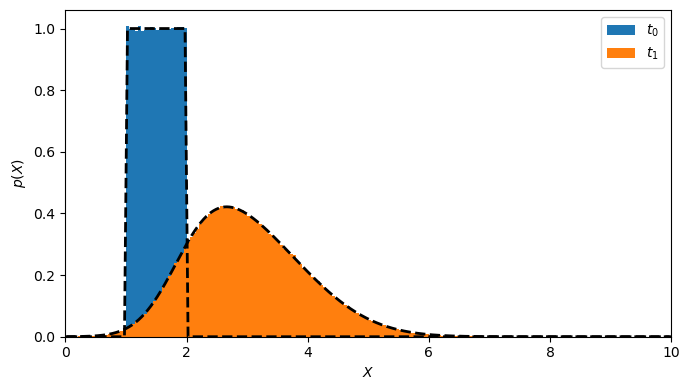

In [3]:
# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    alpha = 1
    return alpha * X

def b(X, t):
    beta = 0.5
    return beta * X + 0.001


# Initial distribution
Np = 1000000
X0 = np.random.uniform(low=1, high=2, size=Np)
# timestep
dt = 1

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)


bins = np.linspace(0, 10, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True, label='$t_0$')
plt.hist(X1, bins=bins, density=True, label='$t_1$')

# Work out and plot the initial (analytical) density
def uniform(x, low=1, high=2):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)

plt.plot(mids, uniform(mids), '--', c='k', lw=2)

# Transition density
def p(x1, t1, x0, t0):
    return np.exp(-0.5*((x1 - (x0 + a(x0, t0)*(t1-t0)))**2 / (b(x0, t0)**2 * (t1-t0)))) / np.sqrt(2*np.pi*b(x0, t0)**2 * (t1-t0))

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(0, 10, 2000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0) * uniform(x[None,:]), axis=1)

plt.plot(x, p1, '--', c='k', lw=2)


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(0, 10)
plt.legend()
plt.tight_layout()

## Applying Chapman-Kolmogorov to Euler-Maruyama with reflecting boundaries


We can also apply the Chapman-Kolmogorov equation to Euler-Maruyama with reflecting boundaries. Since the transition function for a single step with Euler-Maruyama is a Gaussian with mean $\mu=X_n + a(X_n, t_n) \, \Delta t$, the effect of a reflecting boundary can be taken into account simply by adding a Gaussian whose mean is mirrored about the boundary.

We find that the transition function from $X_n$ to $X_{n+1}$, with reflecting boundaries at $x_\mathrm{min}$ and $x_\mathrm{max}$ is a sum of three Gaussians with means

\begin{align}
\mu_\mathrm{orig} &= X_n  + a(X_n, t_n) \, \Delta t \\
\mu_\mathrm{left} &= x_\mathrm{min} - \big(\mu_\mathrm{orig} - x_\mathrm{min}\big) \\
\mu_\mathrm{right} &= x_\mathrm{max} + \big(x_\mathrm{max} - \mu_\mathrm{orig} \big)
\end{align}

and all with variance $\sigma^2 = \big(b(X_n, t_n)\big)^2 \Delta t$. And of course we have to set $p(x_1, t_1 | x_0, t_0)$ to zero for any $x_1 < x_\mathrm{min}$ or $x_1 > x_\mathrm{max}$.

**Note:** If the timestep is so long that multiple reflection is an issue, we need to include additional terms in the transition probability density. A useful test can be to check the integral of $p$, it should be equal to 1.

This is illustrated below, by comparing the distribution after a single step with Euler-Maruyama to the (numerically) integrated Chapman-Kolmogorov equation.

In [4]:
def reflect(X, xmin=0, xmax = 2):
    # Reflect as many times as needed, until all particles are inside
    while np.any((X < xmin) | (X > xmax)): # Note that | is shorthand for np.logical_or in this case
        X = np.where(X < xmin, X+2*(xmin - X), X)
        X = np.where(X > xmax, X+2*(xmax - X), X)
    return X

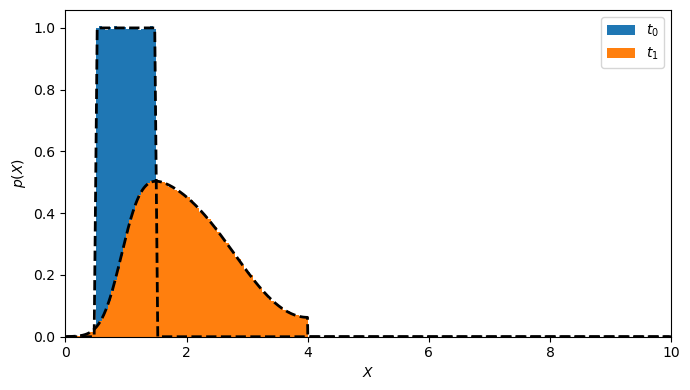

In [5]:
# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    alpha = 1
    return alpha * X

def b(X, t):
    beta = 0.5
    return beta * X + 0.001

xmin=0
xmax=4

# Initial distribution
Np = 1000000
X0 = np.random.uniform(low=0.5, high=1.5, size=Np)
# timestep
dt = 1

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)


bins = np.linspace(0, 10, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True, label='$t_0$')
plt.hist(X1, bins=bins, density=True, label='$t_1$')

# Work out and plot the initial (analytical) density
def uniform(x, low=0.5, high=1.5):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)

plt.plot(mids, uniform(mids), '--', c='k', lw=2)

# Transition density
def p(x1, t1, x0, t0, xmin, xmax):
    sigma = np.sqrt(b(x0, t0)**2 * (t1-t0))
    mu_1 = (x0 + a(x0, t0)*(t1-t0))
    mu_left = xmin - (mu_1 - xmin)
    mu_right = xmax + (xmax - mu_1)
    p_1 = ( 1 / (np.sqrt(2*np.pi)*sigma) ) * (
        np.exp(-0.5*((x1 - mu_1)**2 / sigma**2)) 
        +np.exp(-0.5*((x1 - mu_left)**2 / sigma**2))
        +np.exp(-0.5*((x1 - mu_right)**2 / sigma**2))
              )
    return np.where((xmin <= x1) & (x1 <= xmax), p_1, 0.0)

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(0, 10, 2000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:]), axis=1)

plt.plot(x, p1, '--', c='k', lw=2)


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(0, 10)
plt.legend(loc='upper right')
plt.tight_layout()

## Applying Chapman-Kolmogorov to the well-mixed condition

Wilson & Flesch (1993) point out that we can use the Chapman-Kolmogorov equation to study the degree to which a numerical scheme with reflection satisfies the well-mixed condition, and that it is enough to look at the effect of a single step. The idea is simply to apply Chapman-Kolmogorov to a single step of the numerical schemes, for a well mixed initial condition. If the well-mixed condition is not satisfied after a single step, then it will not be satisfied after several steps either.

This is illustrated below.

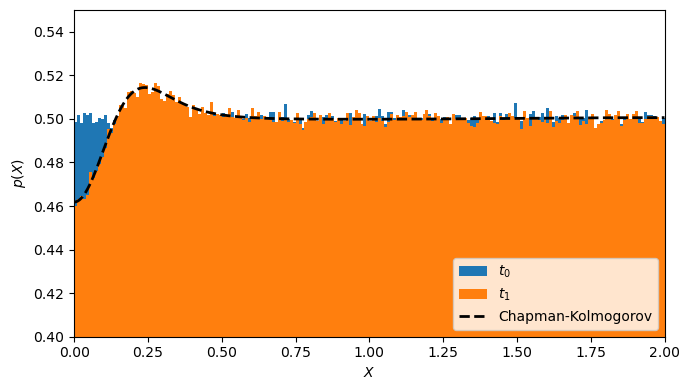

In [6]:
K0 = 1e-3
K1 = 2e-2

# Define diffusivity
def K(x):
    return K1 * x + K0

# Define derivative of the diffusivity
def dKdx(x):
    return K1

# Define functions a and b
def a(x, t):
    return dKdx(x)

def b(x, t):
    return np.sqrt(2*K(x))

xmin=0
xmax=2

# Initial distribution
Np = 10000000
X0 = np.random.uniform(low=xmin, high=xmax, size=Np)
# timestep
dt = 5

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)


bins = np.linspace(xmin, xmax, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True, label='$t_0$')
plt.hist(X1, bins=bins, density=True, label='$t_1$')

# Work out and plot the initial (analytical) density
def uniform(x, low=0, high=1):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)


# Transition density
def p(x1, t1, x0, t0, xmin, xmax):
    sigma = np.sqrt(b(x0, t0)**2 * (t1-t0))
    mu_1 = (x0 + a(x0, t0)*(t1-t0))
    mu_left = xmin - (mu_1 - xmin)
    mu_right = xmax + (xmax - mu_1)
    p_1 = ( 1 / (np.sqrt(2*np.pi)*sigma) ) * (
        np.exp(-0.5*((x1 - mu_1)**2 / sigma**2)) 
        +np.exp(-0.5*((x1 - mu_left)**2 / sigma**2))
        +np.exp(-0.5*((x1 - mu_right)**2 / sigma**2))
              )
    return np.where((xmin <= x1) & (x1 <= xmax), p_1, 0.0)

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(xmin, xmax, 5000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:], low=xmin, high=xmax), axis=1)

plt.plot(x, p1, '--', c='k', lw=2, label='Chapman-Kolmogorov')


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(0, 2)
plt.ylim(0.4, 0.55)
plt.legend(loc='lower right')
plt.tight_layout()

## A closer look at the boundary issue: Reflecting boundary and reflected domain.

Above, we looked at the domain $x \in [0, 1]$ with reflecting boundaries, and a linearly increasing diffusivity given by

$$ K(x) = K_0 + x K_1, $$

and we found that the numerical solution deviated from the well-mixed condition, particularly near the boundary at $x=0$.

Now, we will consider a modified problem: We will look at the domain $x \in [-1, 1]$, with diffusivity given by

$$ K(x) = K_0 + |x| K_1. $$

In other words, we have extended the domain by mirroring it about the point $x=0$. This is illustrated below:

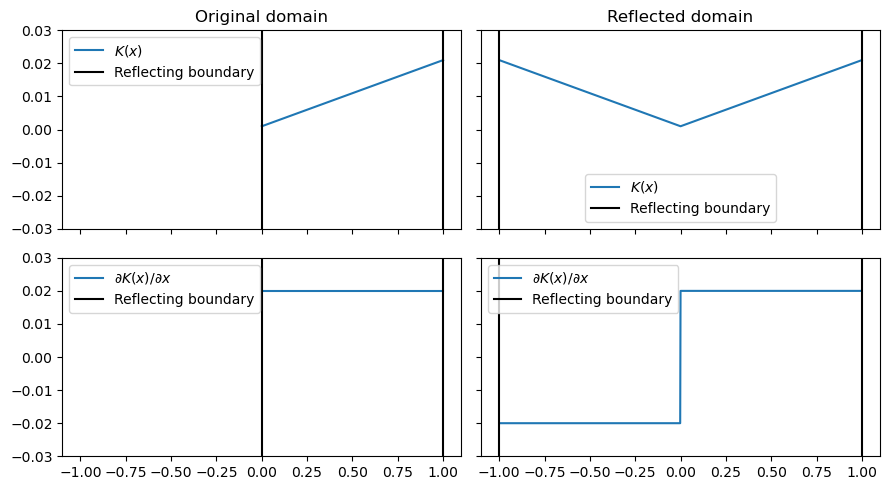

In [7]:
K0 = 1e-3
K1 = 2e-2

# Define diffusivity
def K(x):
    return K1 * np.abs(x) + K0

# Define derivative of the diffusivity
def dKdx(x):
    return np.where(x >= 0, K1, -K1)

fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(9,5))

x = np.linspace(0, 1, 101)
# Plot original diffusivity
ax[0,0].plot(x, K(x), label='$K(x)$')
ax[0,0].plot([0,0], [-1,1], c='k', label='Reflecting boundary')
ax[0,0].plot([1,1], [-1,1], c='k')
ax[0,0].legend()
# Plot original derivative of diffusivity
ax[1,0].plot(x, dKdx(x), label='$\partial K(x)/\partial x$')
ax[1,0].plot([0,0], [-1,1], c='k', label='Reflecting boundary')
ax[1,0].plot([1,1], [-1,1], c='k')
ax[1,0].legend()

x = np.linspace(-1, 1, 1001)
# Plot original diffusivity
ax[0,1].plot(x, K(x), label='$K(x)$')
ax[0,1].plot([-1,-1], [-1,1], c='k', label='Reflecting boundary')
ax[0,1].plot([1,1], [-1,1], c='k')
ax[0,1].legend()
# Plot original derivative of diffusivity
ax[1,1].plot(x, dKdx(x), label='$\partial K(x)/\partial x$')
ax[1,1].plot([-1,-1], [-1,1], c='k', label='Reflecting boundary')
ax[1,1].plot([1,1], [-1,1], c='k')
ax[1,1].legend()

ax[0,0].set_ylim(-1.5*K1, 1.5*K1)
ax[0,0].set_title('Original domain')
ax[0,1].set_title('Reflected domain')
plt.tight_layout()

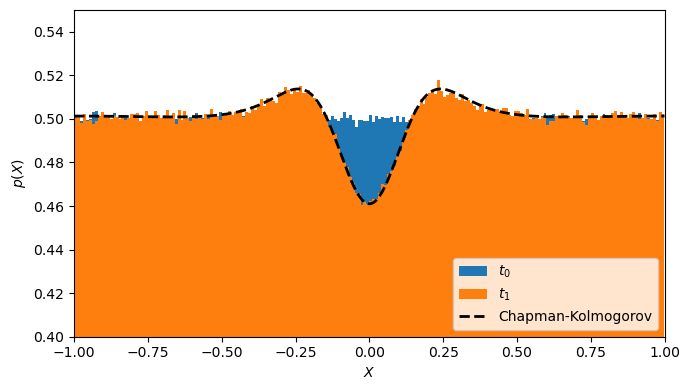

In [8]:
K0 = 1e-3
K1 = 2e-2

# Define diffusivity
def K(x):
    return K1 * np.abs(x) + K0

# Define derivative of the diffusivity
def dKdx(x):
    return np.where(x >= 0, K1, -K1)

# Define functions a and b
def a(x, t):
    return dKdx(x)

def b(x, t):
    return np.sqrt(2*K(x))

xmin=-1
xmax=1

# Initial distribution
Np = 20000000
X0 = np.random.uniform(low=xmin, high=xmax, size=Np)
# timestep
dt = 5

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)


bins = np.linspace(xmin, xmax, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True, label='$t_0$')
plt.hist(X1, bins=bins, density=True, label='$t_1$')

# Work out and plot the initial (analytical) density
def uniform(x, low=xmin, high=xmax):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)


# Transition density
def p(x1, t1, x0, t0, xmin, xmax):
    sigma = np.sqrt(b(x0, t0)**2 * (t1-t0))
    mu_1 = (x0 + a(x0, t0)*(t1-t0))
    mu_left = xmin - (mu_1 - xmin)
    mu_right = xmax + (xmax - mu_1)
    p_1 = ( 1 / (np.sqrt(2*np.pi)*sigma) ) * (
        np.exp(-0.5*((x1 - mu_1)**2 / sigma**2)) 
        +np.exp(-0.5*((x1 - mu_left)**2 / sigma**2))
        +np.exp(-0.5*((x1 - mu_right)**2 / sigma**2))
              )
    return np.where((xmin <= x1) & (x1 <= xmax), p_1, 0.0)

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(xmin, xmax, 10000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:]), axis=1)

plt.plot(x, p1, '--', c='k', lw=2, label='Chapman-Kolmogorov')


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(-1, 1)
plt.ylim(0.4, 0.55)
plt.legend(loc='lower right')
plt.tight_layout()

Integral of C-K:  1.0003044721678935
Integral of C-K:  1.0002001186157383


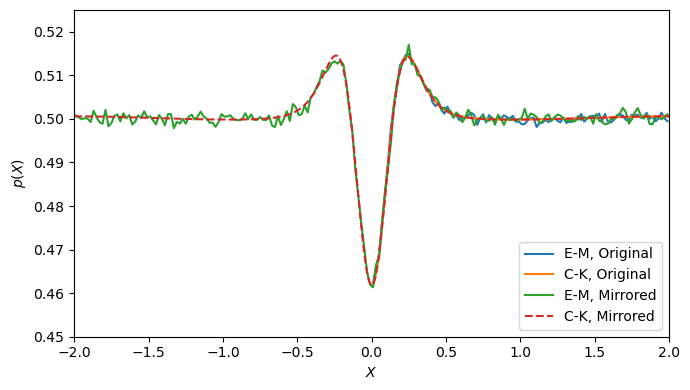

In [9]:
K0 = 1e-3
K1 = 2e-2

# timestep
dt = 5
t0 = 0
t1 = t0 + dt

# Number of particles
Np = 50000000


# Define diffusivity
def K(x):
    return K1 * np.abs(x) + K0

# Define derivative of the diffusivity
def dKdx(x):
    return np.where(x > 0, K1, -K1)

# Define functions a and b
def a(x, t):
    return dKdx(x)

def b(x, t):
    return np.sqrt(2*K(x))

# Initial (analytical) density
def uniform(x, low=0, high=1):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)

# Transition density
def p(x1, t1, x0, t0, xmin, xmax):
    sigma = np.sqrt(b(x0, t0)**2 * (t1-t0))
    mu_1 = (x0 + a(x0, t0)*(t1-t0))
    mu_left = xmin - (mu_1 - xmin)
    mu_right = xmax + (xmax - mu_1)
    p_1 = ( 1 / (np.sqrt(2*np.pi)*sigma) ) * (
        np.exp(-0.5*((x1 - mu_1)**2 / sigma**2)) 
        +np.exp(-0.5*((x1 - mu_left)**2 / sigma**2))
        +np.exp(-0.5*((x1 - mu_right)**2 / sigma**2))
              )
    return np.where((xmin <= x1) & (x1 <= xmax), p_1, 0.0)

# Histogram bins
bins = np.linspace(-2, 2, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins


fig = plt.figure(figsize=(7,4))

# Original domain
xmin=0
xmax=2

# Initial distribution
X0 = np.random.uniform(low=xmin, high=xmax, size=Np)
# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)
# Plot the final particle distribution
hist, _ = np.histogram(X1, bins=bins, density=True)
plt.plot(mids[mids >= 0], hist[mids >= 0], label='E-M, Original')

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(xmin, xmax, 5000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:], low=xmin, high=xmax), axis=1)
plt.plot(x, p1, '-', label='C-K, Original')

print('Integral of C-K: ', dx*np.sum(p1))

# Mirrored domain
xmin=-2
xmax=2

# Initial distribution
X0 = np.random.uniform(low=xmin, high=xmax, size=Np)
# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)
# Plot the final particle distribution
hist, _ = np.histogram(X1, bins=bins, density=True)
plt.plot(mids, 2*hist, label='E-M, Mirrored')

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(xmin, xmax, 10001, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:], low=xmin, high=xmax), axis=1)
plt.plot(x, 2*p1, '--', label='C-K, Mirrored')

print('Integral of C-K: ', dx*np.sum(p1))


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(-2, 2)
plt.ylim(0.45, 0.525)
plt.legend(loc='lower right')
plt.tight_layout()

## What can we conclude from this?

It looks like the reflection issue is not a problem with the reflection scheme itself, but rather that using a diffusivity, $K(x)$ with a non-zero derivative at the boundary effectively is the same as using a diffusivity with a discontinuous derivative. And we recall that $a$ and $b$ being "moderately smooth functions" were a condition for the validity of the Fokker-Planck equation, which we used to derive an SDE consistent with the diffusion equation.

And as we observed in the exercise, we can reduce this issue by using a diffusivity with zero derivative at the boundary.

Finally, we will try to come up with a predictive measure of the magnitude of the problem. We still use the same diffusivity, $K(x) = K_0 + x K_1$. Consider a particle exactly at the boundary at $x=0$, and say we draw $\mathrm{d}W = \sqrt{\Delta t}$, then the particle will jump to the right, to the point

$$ h_1 = K_1 \Delta t + \sqrt{K_0} \Delta t.$$

If, on the other hand, $\mathrm{d} W  = -\sqrt{\Delta t}$, the particle may be reflected, and will end up at the pont

$$ h_2 = \left| K_1 \Delta t - \sqrt{K_0} \Delta t \right|.$$

In the example below, we indicate the positions of $h_1$ and $h_2$ in the plot, to see if this seems useful.

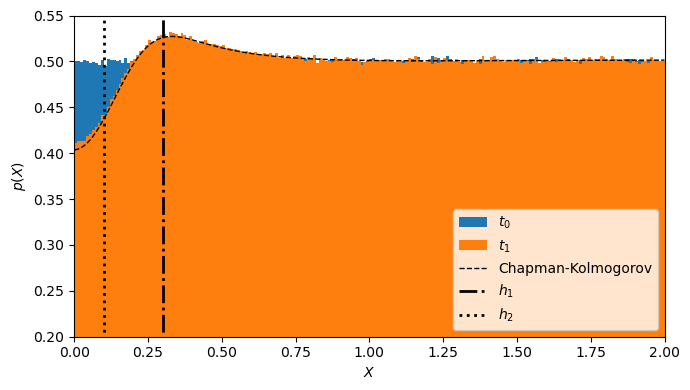

In [10]:
K0 = 1e-3
K1 = 4e-2

# Define diffusivity
def K(x):
    return K1 * x + K0

# Define derivative of the diffusivity
def dKdx(x):
    return K1

# Define functions a and b
def a(x, t):
    return dKdx(x)

def b(x, t):
    return np.sqrt(2*K(x))

xmin=0
xmax=2

# Initial distribution
Np = 10000000
X0 = np.random.uniform(low=xmin, high=xmax, size=Np)
# timestep
dt = 5

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)
# Reflect
X1 = reflect(X1, xmin=xmin, xmax=xmax)


bins = np.linspace(xmin, xmax, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True, label='$t_0$')
plt.hist(X1, bins=bins, density=True, label='$t_1$')

# Work out and plot the initial (analytical) density
def uniform(x, low=0, high=1):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)


# Transition density
def p(x1, t1, x0, t0, xmin, xmax):
    sigma = np.sqrt(b(x0, t0)**2 * (t1-t0))
    mu_1 = (x0 + a(x0, t0)*(t1-t0))
    mu_left = xmin - (mu_1 - xmin)
    mu_right = xmax + (xmax - mu_1)
    p_1 = ( 1 / (np.sqrt(2*np.pi)*sigma) ) * (
        np.exp(-0.5*((x1 - mu_1)**2 / sigma**2)) 
        +np.exp(-0.5*((x1 - mu_left)**2 / sigma**2))
        +np.exp(-0.5*((x1 - mu_right)**2 / sigma**2))
              )
    return np.where((xmin <= x1) & (x1 <= xmax), p_1, 0.0)

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(xmin, xmax, 5000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0, xmin, xmax) * uniform(x[None,:], low=xmin, high=xmax), axis=1)

plt.plot(x, p1, '--', c='k', lw=1, label='Chapman-Kolmogorov')

# Plot values of h1 and h2

h1 = a(0., t0) * dt + b(0., t0)*np.sqrt(dt)
h2 = np.abs(a(0., t0) * dt - b(0., t0)*np.sqrt(dt))

plt.plot([h1, h1], [0, 2], '-.', lw=2, c='k', label='$h_1$')
plt.plot([h2, h2], [0, 2], ':', lw=2, c='k', label='$h_2$')

plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(0, 2)
plt.ylim(0.2, 0.55)
plt.legend(loc='lower right')
plt.tight_layout()

# References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5


Wilson, J. D., & Flesch, T. K. (1993). "Flow boundaries in random-flight dispersion models: enforcing the well-mixed condition". _Journal of Applied Meteorology and Climatology_, 32(11), 1695-1707. [https://doi.org/10.1175/1520-0450(1993)032<1695:FBIRFD>2.0.CO;2](https://doi.org/10.1175/1520-0450(1993)032<1695:FBIRFD>2.0.CO;2)